<a href="https://colab.research.google.com/github/mananm98/Hindi-Text-Classification/blob/master/Hindi_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hindi Wikipedia Articles Language Model**

In [2]:
!pip install sentencepiece

In [0]:
from fastai.basics import *
from fastai.text import *
import warnings
import sentencepiece
warnings.filterwarnings('ignore')
from os import path 
from time import time
import pandas as pd
import sentencepiece as spm
import os
import shutil

In [4]:
cd /content/drive/My Drive/Hindi

/content/drive/My Drive/Hindi


In [0]:
def get_data(dump_url, lang):
    ''' 1) Download thw Wikipedia-dump file
        2) Unzip it
        3) Convert to text using WikiExtractor tool from Github
    '''
    if path.exists(f"./{lang}-wiki-data"):
        print(f"{lang} wiki data already exists not downloading !")
    else:
        path_to_store = f"./{lang}-wiki-data.xml.bz2"
        print('Downloading ....')
        download_url(dump_url,path_to_store)
        print('unzipping ....')
        bunzip(path_to_store)
      
    if not path.exists('./wikiextractor'): 
        os.system('git clone https://github.com/attardi/wikiextractor.git')
      
    print('extracting ....')
    os.system('python wikiextractor/WikiExtractor.py --processes 2 --no_templates --min_text_length 200 --filter_disambig_pages --log_file log -b 100G -q '+ f"./{lang}-wiki-data.xml" )       

In [0]:
url = "https://dumps.wikimedia.org/hiwiki/20200501/hiwiki-20200501-pages-meta-current.xml.bz2"
language = 'Hindi'

get_data(dump_url=url, lang=language)

unzipping ....
extracting ....


In [0]:
# Renaming file as Hindi-Text
shutil.move('./text/AA/wiki_00' , './Hindi-text')
shutil.rmtree('./text')

In [0]:
# sample 
!head -n4 './Hindi-text'

<doc id="10" url="https://hi.wikipedia.org/wiki?curid=10" title="हम होंगे कामयाब">
हम होंगे कामयाब

हम होंगे कामयाब ( का गिरिजा कुमार माथुर द्वारा किया गया हिंदी भावानुवाद) एक प्रतिरोध गीत है। यह गीत बीसवीं सदी में नागरिक अधिकार आंदोलन का प्रधान स्वर बना। इस गीत को आमतौर पर "I'll Overcome Some Day" ("आई विल ओवरकम सम डे") से काव्यावतरित माना जाता है, जो चार्ल्स अल्बर्ट टिंडले द्वारा गाया गया था और जिसे 1900 में पहली बार प्रकाशित किया गया था।


In [0]:
with open('./Hindi-text','r') as f:
    lines = f.readlines()

print(len(lines))
lines = [line for line in lines if line != '\n'] # Removing '\n' from lines    
print(len(lines))

1334446
711662


In [0]:
lines[:5]

['<doc id="10" url="https://hi.wikipedia.org/wiki?curid=10" title="हम होंगे कामयाब">\n',
 'हम होंगे कामयाब\n',
 'हम होंगे कामयाब ( का गिरिजा कुमार माथुर द्वारा किया गया हिंदी भावानुवाद) एक प्रतिरोध गीत है। यह गीत बीसवीं सदी में नागरिक अधिकार आंदोलन का प्रधान स्वर बना। इस गीत को आमतौर पर "I\'ll Overcome Some Day" ("आई विल ओवरकम सम डे") से काव्यावतरित माना जाता है, जो चार्ल्स अल्बर्ट टिंडले द्वारा गाया गया था और जिसे 1900 में पहली बार प्रकाशित किया गया था।\n',
 '</doc>\n',
 '<doc id="14" url="https://hi.wikipedia.org/wiki?curid=14" title="दैनिक पूजा">\n']

In [0]:
# pattern to find title
title_re = re.compile(r'<doc id="\d+" url="https://hi.wikipedia.org/wiki\?curid=\d+" title="([^"]+)">')

In [4]:
title_re.findall('<doc id="10" url="https://hi.wikipedia.org/wiki?curid=10" title="हम होंगे कामयाब">\n')

['हम होंगे कामयाब']

In [0]:
for line in lines:
    
    if line.startswith('<doc id='):
        title = title_re.findall(line)[0].replace('/','_')
        f = open(f'./wiki-files/{title}.txt',"a")
        continue
       
    if line.startswith('</doc>'):
        f.close()
        continue
       
    if line == title+'\n' :
        continue
        
    f.write(line)
    

In [0]:
# Replacing 'whitespaces' and ',' in file-names with '_' as sentencepiece.trainer cannot read files with 'whitespaces' and ','
file_list = os.listdir('./wiki-files')
path = '/content/drive/My Drive/Hindi/wiki-files'
for fname in file_list:
    os.rename(os.path.join(path, fname) , os.path.join(path, fname.replace(' ','_').replace(',','_')))
    

In [17]:
file_list = os.listdir('./wiki-files')
print("No. of files ---> ", len(file_list),'\n\n')

# file_list : list of all file paths in wiki-files, it would be given to sentencepiece.trainer for training
path = './wiki-files/'
file_list = [path + fname for fname in file_list]
print(file_list[:3],'\n\n')

file_list = ','.join(file_list)
print(file_list[:80])

No. of files --->  71989 


['./wiki-files/विजयवाड़ा_जंक्शन_रेलवे_स्टेशन.txt', './wiki-files/सद्धर्म_प्रचारक.txt', './wiki-files/गीता_रामजी.txt'] 


./wiki-files/विजयवाड़ा_जंक्शन_रेलवे_स्टेशन.txt,./wiki-files/सद्धर्म_प्रचारक.txt,


In [0]:
model_name = 'spm'
vocab_size = 30000
spm.SentencePieceTrainer.train(f'--input={file_list} --vocab_size={vocab_size} --model_prefix={model_name}')

### **Creating Hindi Wikipedia-Articles Databunch object**
- This databunch object will be given to the language model learner
- The databunch object, is used to represent a dataset 
- It is used inside fastai's Learner to train a model

In [0]:
bs = 128 # batch size
start = time()
data = (TextList.from_folder('./wiki-files',processor = [OpenFileProcessor(),SPProcessor( sp_model = './spm.model', sp_vocab = './spm.vocab')])
        .split_by_rand_pct(0.1,seed = 42)
        .label_for_lm()
        .databunch(bs = bs, num_workers = 1))

end = time()
print( "time Taken ", start - end)

time Taken  -500.40979528427124


In [0]:
data.save('./Hindi_databunch')
len(data.vocab.itos),len(data.train_ds)

(30000, 64787)

In [0]:
bs = 128     # batch size
data = load_data(path = './',file = 'Hindi_databunch' , bs = bs)

In [0]:
data.vocab.itos[5:20]

['▁में',
 ',',
 '▁है',
 '▁की',
 '▁और',
 '▁से',
 '▁का',
 '▁को',
 '▁हैं',
 '▁एक',
 '▁',
 '▁पर',
 '▁(',
 '-',
 ')']

In [0]:
# Creating Language model Learner
learn = language_model_learner(data, AWD_LSTM, drop_mult = 0.5, pretrained = False)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


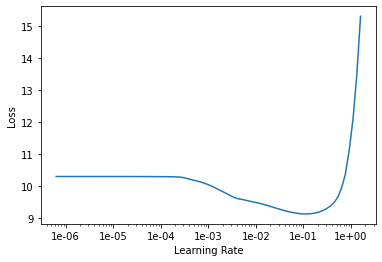

In [0]:
# Finding a suitable learning rate 
learn.lr_find()
learn.recorder.plot()

In [0]:
# Learning rate
lr = 1e-3
lr *= bs/48

In [0]:
# Training language model on Hindi Wikipedia Articles Dataset for 10 epochs, using fit_one_cycle policy
learn.unfreeze()
path = '/content/drive/My Drive/Hindi/models/'
for i in range(10):
  learn.fit_one_cycle(1, lr, moms = (0.8,0.7))
  learn.to_fp32().save(path+f'model_{i+1}', with_opt = False)


epoch,train_loss,valid_loss,accuracy,time
0,4.598891,4.537275,0.276804,20:22


epoch,train_loss,valid_loss,accuracy,time
0,4.413353,4.325689,0.292641,20:18


epoch,train_loss,valid_loss,accuracy,time
0,4.294977,4.225444,0.301208,20:15


epoch,train_loss,valid_loss,accuracy,time
0,4.244415,4.164065,0.307011,20:19


epoch,train_loss,valid_loss,accuracy,time
0,4.169816,4.122560,0.310859,20:18


epoch,train_loss,valid_loss,accuracy,time
0,4.103697,4.091389,0.313952,20:17


epoch,train_loss,valid_loss,accuracy,time
0,4.057064,4.067785,0.316389,20:18


epoch,train_loss,valid_loss,accuracy,time
0,4.048289,4.048549,0.318343,20:19


epoch,train_loss,valid_loss,accuracy,time
0,4.009545,4.034369,0.319879,20:17


epoch,train_loss,valid_loss,accuracy,time
0,4.025363,4.022080,0.321042,20:16


In [0]:
learn = learn.load('/content/drive/My Drive/Hindi/models/model_10')

In [0]:
learn.data.vocab.save('/content/drive/My Drive/Hindi/models/model_10_vocab.pkl')

In [0]:
lm_fns = ['model_10','model_10_vocab']

### **Predictions**

In [0]:
# Language model predictions
learn.predict('हिन्दू देवता हनुमान',n_words=15).replace('▁','')

'हिन्दू देवता हनुमान का जन्म हुआ था , भगवान विष्णु ने विश्व मूर्ति बनाकर अपने पूर्वजों की रक्षा'

In [0]:
learn.predict('क्या कर रहे हो',n_words=15).replace('▁','')

'क्या कर रहे हो भारत सरकार द्वारा प्रकाशित 2007 की एक फ़िल्म है । इस फ़िल्म के बैनर तले'

In [0]:
learn.predict('होली',n_words=15).replace('▁','')

'होली के उत्सव सैर गाह निर्धारक रहस्य पर आधारित मुख्य त्यौहार है । यह मिठाई भारतीय'

# **Hindi Movie Reviews Language Model**


### **Creating 'Hindi movie reviews' databunch object for training language model**

In [0]:
# Merging Training and validation sets for training a Language Model on Hindi Movie Reviews
train_df = pd.read_csv('/content/drive/My Drive/Hindi/hindi-movie-reviews-dataset/train.csv')
val_df = pd.read_csv('/content/drive/My Drive/Hindi/hindi-movie-reviews-dataset/valid.csv')
df = pd.concat([train_df,val_df],sort = False)
print("Total No. of reviews ---> ", len(df))
df.head()

Total No. of reviews --->  898


,text,experience
0,चंद्रमोहन शर्मा को-प्रड्यूसर और लीड ऐक्टर अक्ष...,2
1,अगर आप इस फिल्म को देखने जा रहे हैं तो सबसे पह...,0
2,बॉलीवुड वाले चोरी-छिपे हॉलीवुड फिल्मों से कहान...,2
3,"बैनर :\nसंजय दत्त प्रोडक्शन्स प्रा.लि., रुपाली...",0
4,1959 में घटित चर्चित नानावटी कांड में एक क्राइ...,1


In [0]:
bs = 128    # batch size
path = './' # Path where you want to save the model
data_lm = (TextList.from_df(df, path, cols='text')
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

# Saving Databunch object
data_lm.save('./Hindi-movie-data-lm')

In [0]:
data_lm = load_data(path = '/content/drive/My Drive/Hindi/' , file = 'Hindi-movie-data-lm' , bs = bs)

In [0]:
# Creating Language Model Learner with pretrained weights and vocab of language model trained on Hindi-Wikipedia-Articles 
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult = 0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


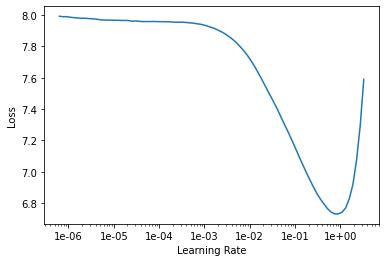

In [0]:
# Finding the best learning rate
learn_lm.lr_find()
learn_lm.recorder.plot()

In [0]:
# Training only last layer of language model
lr = 1e-2
lr *= bs/48
learn_lm.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.992048,4.085779,0.306557,00:12
1,3.975446,3.858138,0.328850,00:12


In [0]:
# Training all the layers
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.429050,3.771845,0.338407,00:16
1,3.487094,3.887578,0.329102,00:16
2,3.480506,3.856337,0.331320,00:16
3,3.293663,3.814256,0.336844,00:16
4,2.975452,3.795635,0.345410,00:16
5,2.506483,3.853560,0.347447,00:16
6,1.908213,4.021800,0.345982,00:16
7,1.432615,4.156212,0.342759,00:16


In [0]:
learn_lm.predict('फिल्म अच्छी थी लेकिन', n_words = 25).replace('▁','')

'फिल्म अच्छी थी लेकिन एक रिवेंज स्टोरी होने के बावजूद यह फिल्म दर्शकों का मनोरंजन करती है । हीरो - हीरोइन का प्रेम सुपरहिट होता है और यही जगह'

In [0]:
learn_lm.save('/content/drive/My Drive/Hindi/models/fine_tuned_model')
learn_lm.save_encoder('/content/drive/My Drive/Hindi/models/fine_tuned_enc')

# **Hindi Movies Reviews Text Classification**

### **Creating 'Hindi movie reviews' Databunch object for classification**

In [0]:
bs = 64
data_cls = (TextList.from_df(train_df, vocab = data_lm.vocab, cols = 'text')
           .split_by_rand_pct(0.1, seed=42)
           .label_from_df(cols='experience')
           .databunch(bs=bs, num_workers=1))

# Saving Hindi-data-classifier
data_cls.save('Hindi-data-classifier')

In [0]:
bs = 32
data_cls = load_data(path = '/content/drive/My Drive/Hindi/',  file = 'Hindi-data-classifier' , bs = bs)

In [0]:
from sklearn.metrics import f1_score

# function to measure f1_score using tensors
# @np_func Converts a function that takes and returns numpy arrays to one that takes and returns tensors
@np_func
def f1(inp,target): 
  return f1_score(target, np.argmax(inp, axis= -1), average = None)

In [0]:
# Creating Text Classification Learner using pretrained encoder from Hindi movie reviews dataset
# fin_tuned_enc has been first trained on Hindi Wikipedia and then Hindi movie reviews dataset
learn_cls = text_classifier_learner(data_cls, AWD_LSTM, drop_mult = 0.5, metrics = [accuracy,f1])
learn_cls.load_encoder('/content/drive/My Drive/Hindi/models/fine_tuned_enc')
learn_cls.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


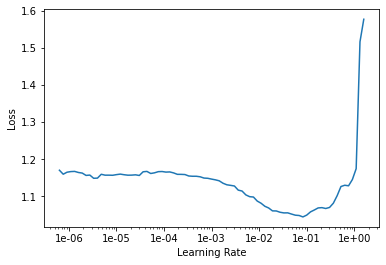

In [8]:
learn_cls.lr_find()
learn_cls.recorder.plot()

In [1]:
!nvidia-smi

Tue May 26 12:19:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
lr = 1e-3

In [10]:
# Training the last group of parameters
learn_cls.fit_one_cycle(2,lr,moms = (0.8,0.7))

In [11]:
# Training the last 2 groups of parameters
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

In [12]:
# Training the last 3 groups of parameters
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

In [13]:
# Training all parameter groups from start till end
learn_cls.unfreeze()
learn_cls.fit_one_cycle(2, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

In [15]:
learn_cls.fit_one_cycle(2, slice(lr/20/(2.6**4),lr/20), moms=(0.8,0.7))

In [17]:
pwd

'/content/drive/My Drive/Hindi'

In [0]:
learn_cls.save('./Text_classifier_model')

In [0]:
learn_cls = learn_cls.load('/content/drive/My Drive/Hindi/models/Text_classifier_model')

In [0]:
# Loading Validation/Test set
test_df = pd.read_csv('/content/drive/My Drive/Hindi/hindi-movie-reviews-dataset/valid.csv')
test_df = test_df.values

In [0]:
preds = []
targets = []
for i in range(len(test_df)):
  preds.append(int(learn_cls.predict(test_df[i][0])[1]))
  targets.append(int(test_df[i][1]))  

In [69]:
preds = np.array(preds)
targets = np.array(targets)
accuracy_on_test = np.sum(preds == targets)/len(test_df)
print(accuracy_on_test)

0.6277777777777778


## **62.7% accuracy on Hindi Movie reviews Test set**